In [1]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
data_path = 'dataset.csv'
data= pd.read_csv(data_path)

In [2]:
#데이터에 결측치는 없는 것을 확인
data.isnull().any()

Marital status                                    False
Application mode                                  False
Application order                                 False
Course                                            False
Daytime/evening attendance                        False
Previous qualification                            False
Nacionality                                       False
Mother's qualification                            False
Father's qualification                            False
Mother's occupation                               False
Father's occupation                               False
Displaced                                         False
Educational special needs                         False
Debtor                                            False
Tuition fees up to date                           False
Gender                                            False
Scholarship holder                                False
Age at enrollment                               

In [3]:
# numerical data에 대하여 이상치 있는지 확인

numerical = ['Application order', 'Age at enrollment','Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd sem (grade)',
       'Curricular units 2nd sem (without evaluations)', 'Unemployment rate', 'Inflation rate', 'GDP']

categorical = []
for col in data.columns[:-1]:
    if col not in numerical:
        categorical.append(col)

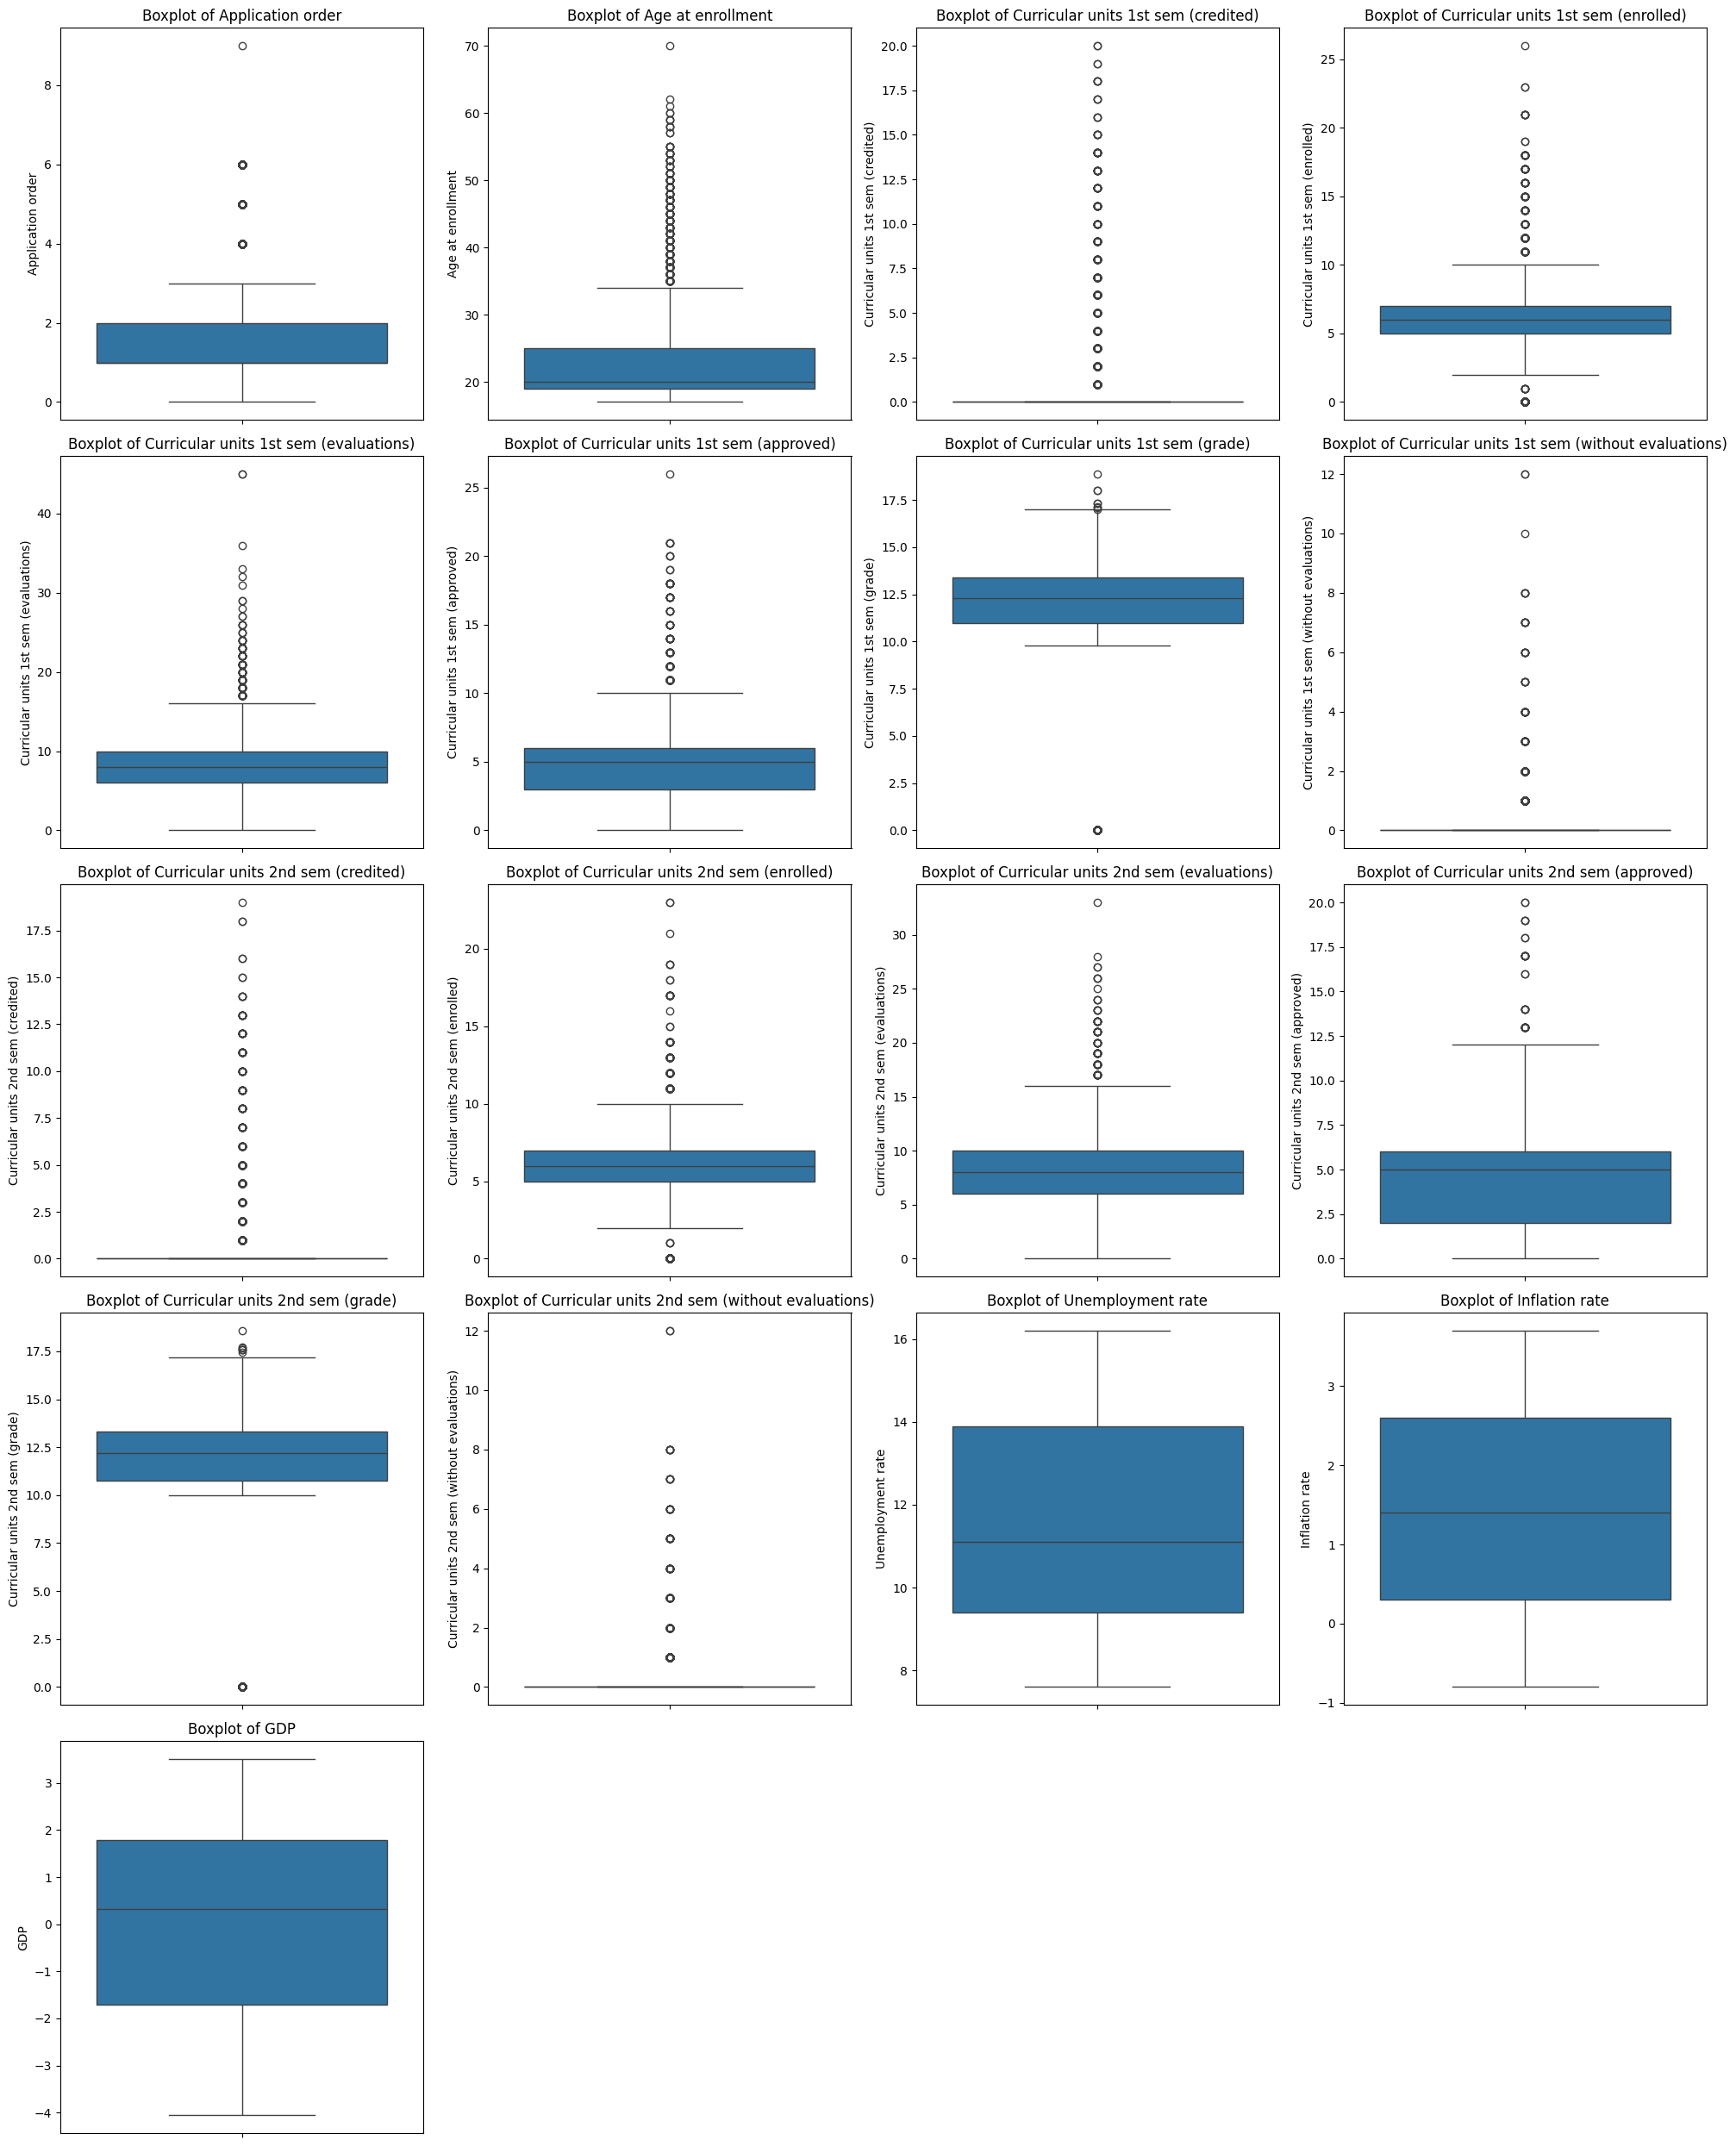

In [4]:
# boxplot으로 우선 시각적으로 파악
fig, axes = plt.subplots(5, 4, figsize=(20, 25))  

for i, col in enumerate(numerical):
    row = i // 4  
    col_num = i % 4  
    sns.boxplot(data=data[col], ax=axes[row, col_num])
    axes[row, col_num].set_title(f'Boxplot of {col}')


for j in range(i + 1, 20):  
    col_num = j % 4
    axes[row, col_num].axis('off')


plt.tight_layout()
plt.show()

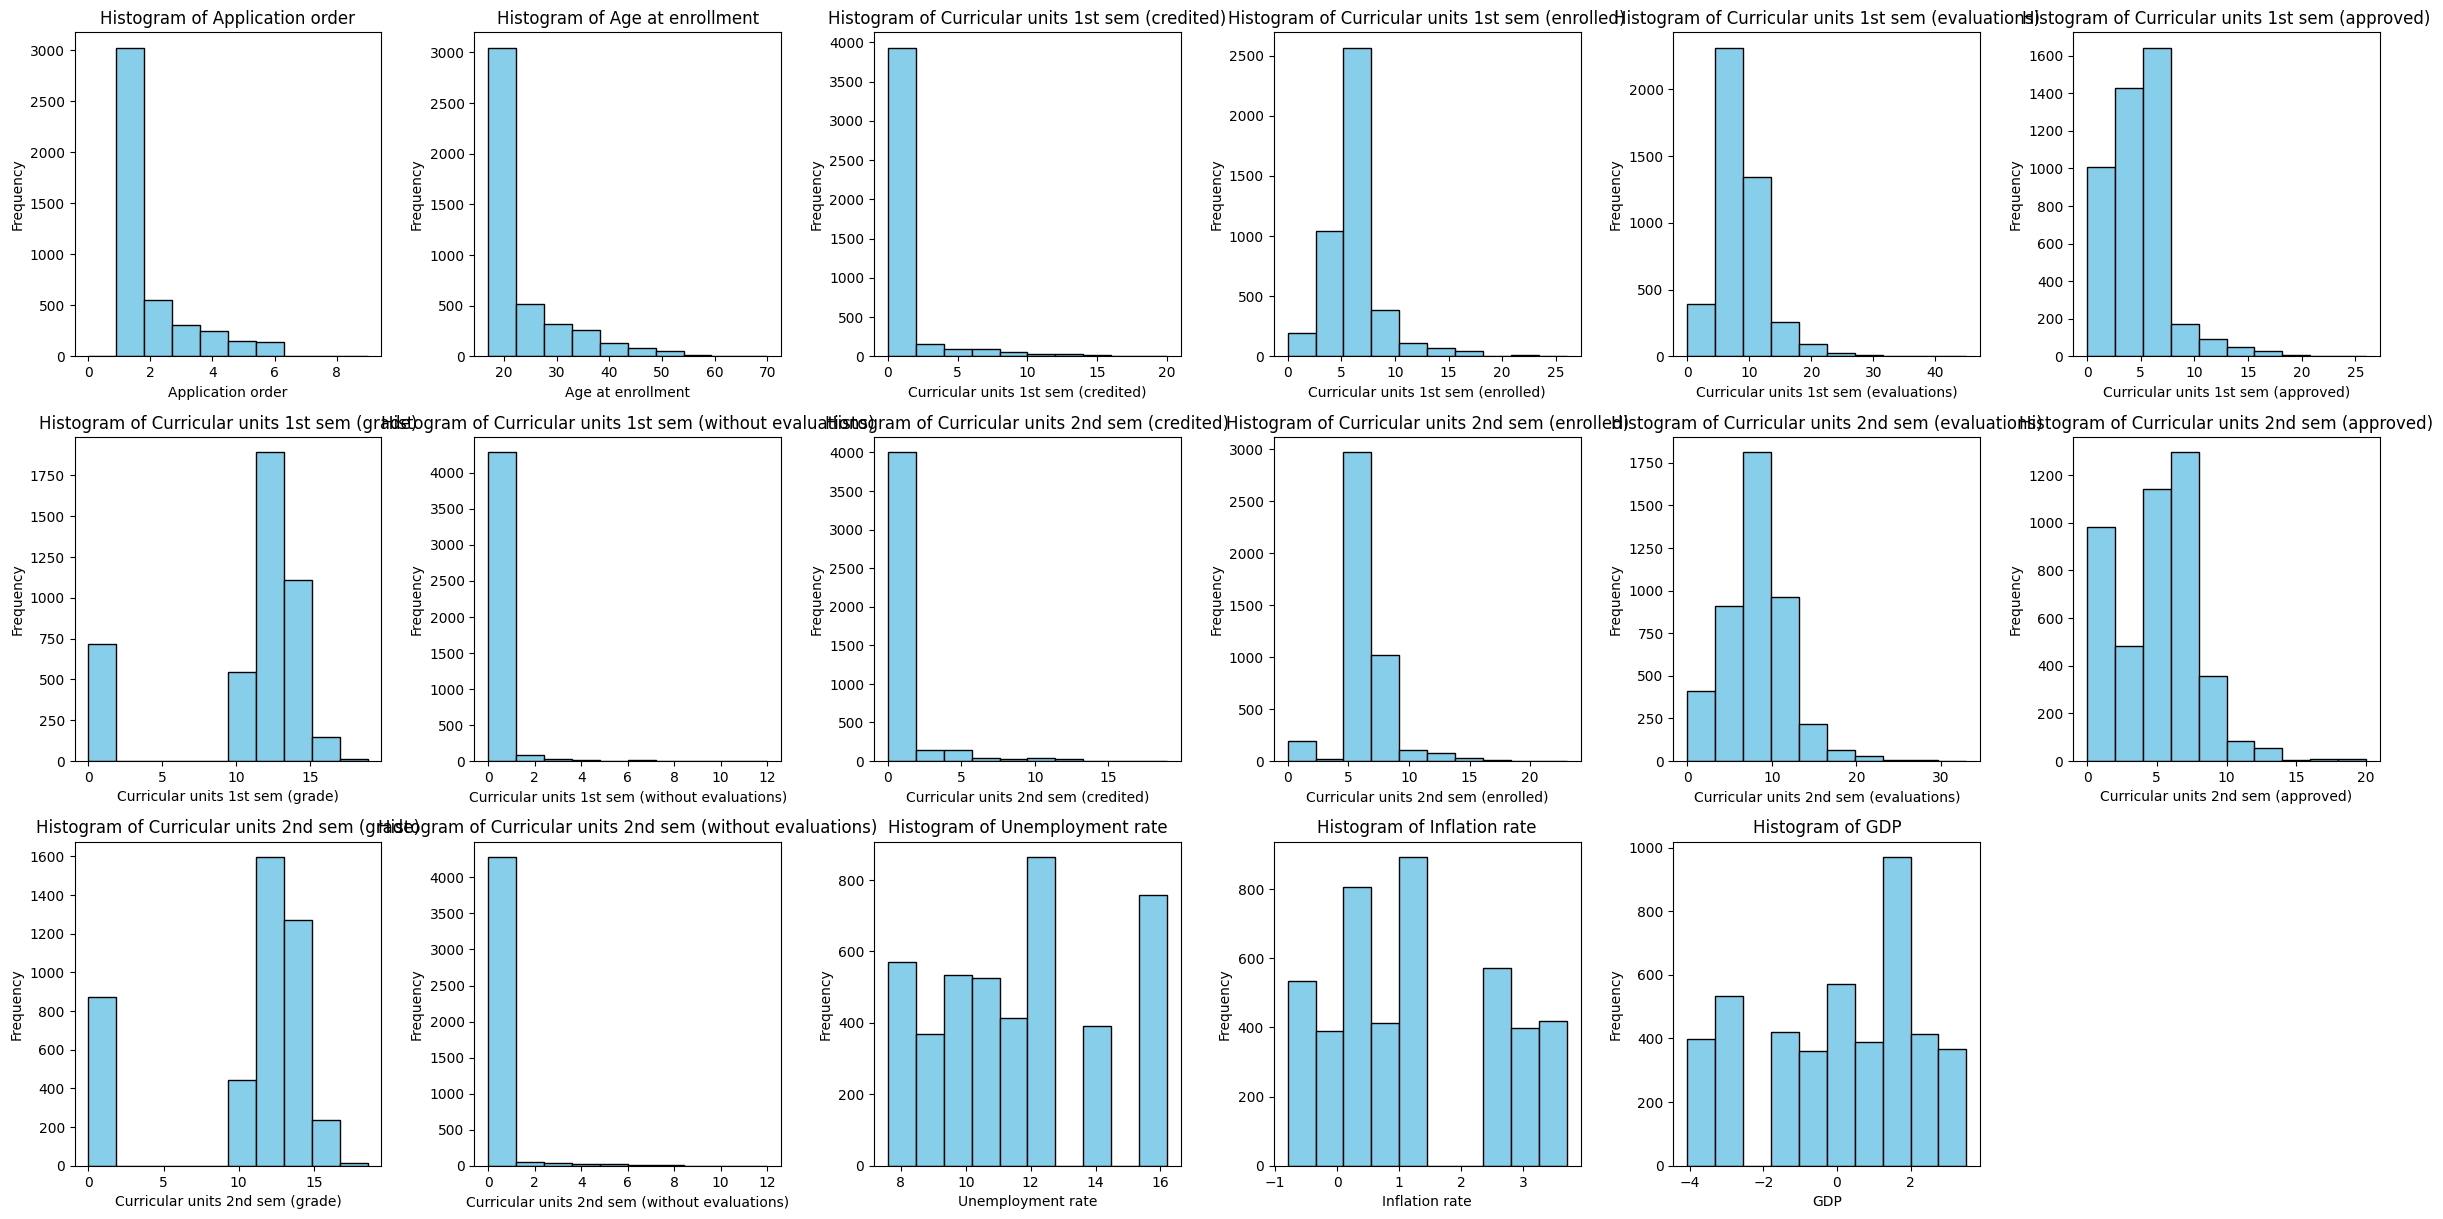

In [5]:
import math
num_columns = len(data.columns)
rows = cols = math.ceil(num_columns ** 0.5)  

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(cols * 4, rows * 4))  
axes = axes.flatten()  

for i, column in enumerate(data[numerical]):
    axes[i].hist(data[column], bins=10, color='skyblue', edgecolor='black')
    axes[i].set_title(f"Histogram of {column}")
    axes[i].set_xlabel(column)
    axes[i].set_ylabel("Frequency")


for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [6]:
import warnings
def remove_rows_with_outliers(df, columns):
    cleaned_df = df.copy() 
    
    rows_to_remove = pd.Series([False] * len(df))
    
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = (df[column] < lower_bound) | (df[column] > upper_bound)
        rows_to_remove |= outliers 
        cleaned_df = cleaned_df[~rows_to_remove]
        warnings.filterwarnings("ignore")
    return cleaned_df

data2 = remove_rows_with_outliers(data, numerical)

len(data2)
# 하나라도 이상치가 있는 경우 행을 제거했는데, 절반 가량이 날아감
# 보다 다른 판단을 할 필요가 있음.

2077

# 이상치 제거


생각해봐야할 것들

단순히 boxplot을 그리고 1.5*IQR을 넘어간다고 해당 데이터가 이상치라 간주할 수 있는가?


이상치 역시 실제로 분포할 수 있는 데이터이다.

무턱대고 이상치를 제거하는 것은 데이터의 양도 줄이고, 데이터를 훼손시킬 수도 있다고 판단

1. 이상치라고 추정되는 값들이 실제 진짜 이상치인가?
2. 이상치 제거 후 데이터의 양이 유의미하게 존재하는가?

# 편향된 데이터에서 이상치 처리방법?

생각해낸 방법 : numerical하지만, 0에 대부분 몰려있기 때문에 0이냐 아니냐로 categorical하게 만들어버리자.


In [7]:
data['Curricular units 1st sem (credited)'] = data['Curricular units 1st sem (credited)'].apply(lambda x: 0 if x == 0 else 1)
data['Curricular units 2nd sem (credited)'] = data['Curricular units 2nd sem (credited)'].apply(lambda x: 0 if x == 0 else 1)
data['Curricular units 1st sem (without evaluations)'] = data['Curricular units 1st sem (without evaluations)'].apply(lambda x: 0 if x == 0 else 1)
data['Curricular units 2nd sem (without evaluations)'] = data['Curricular units 2nd sem (without evaluations)'].apply(lambda x: 0 if x == 0 else 1)

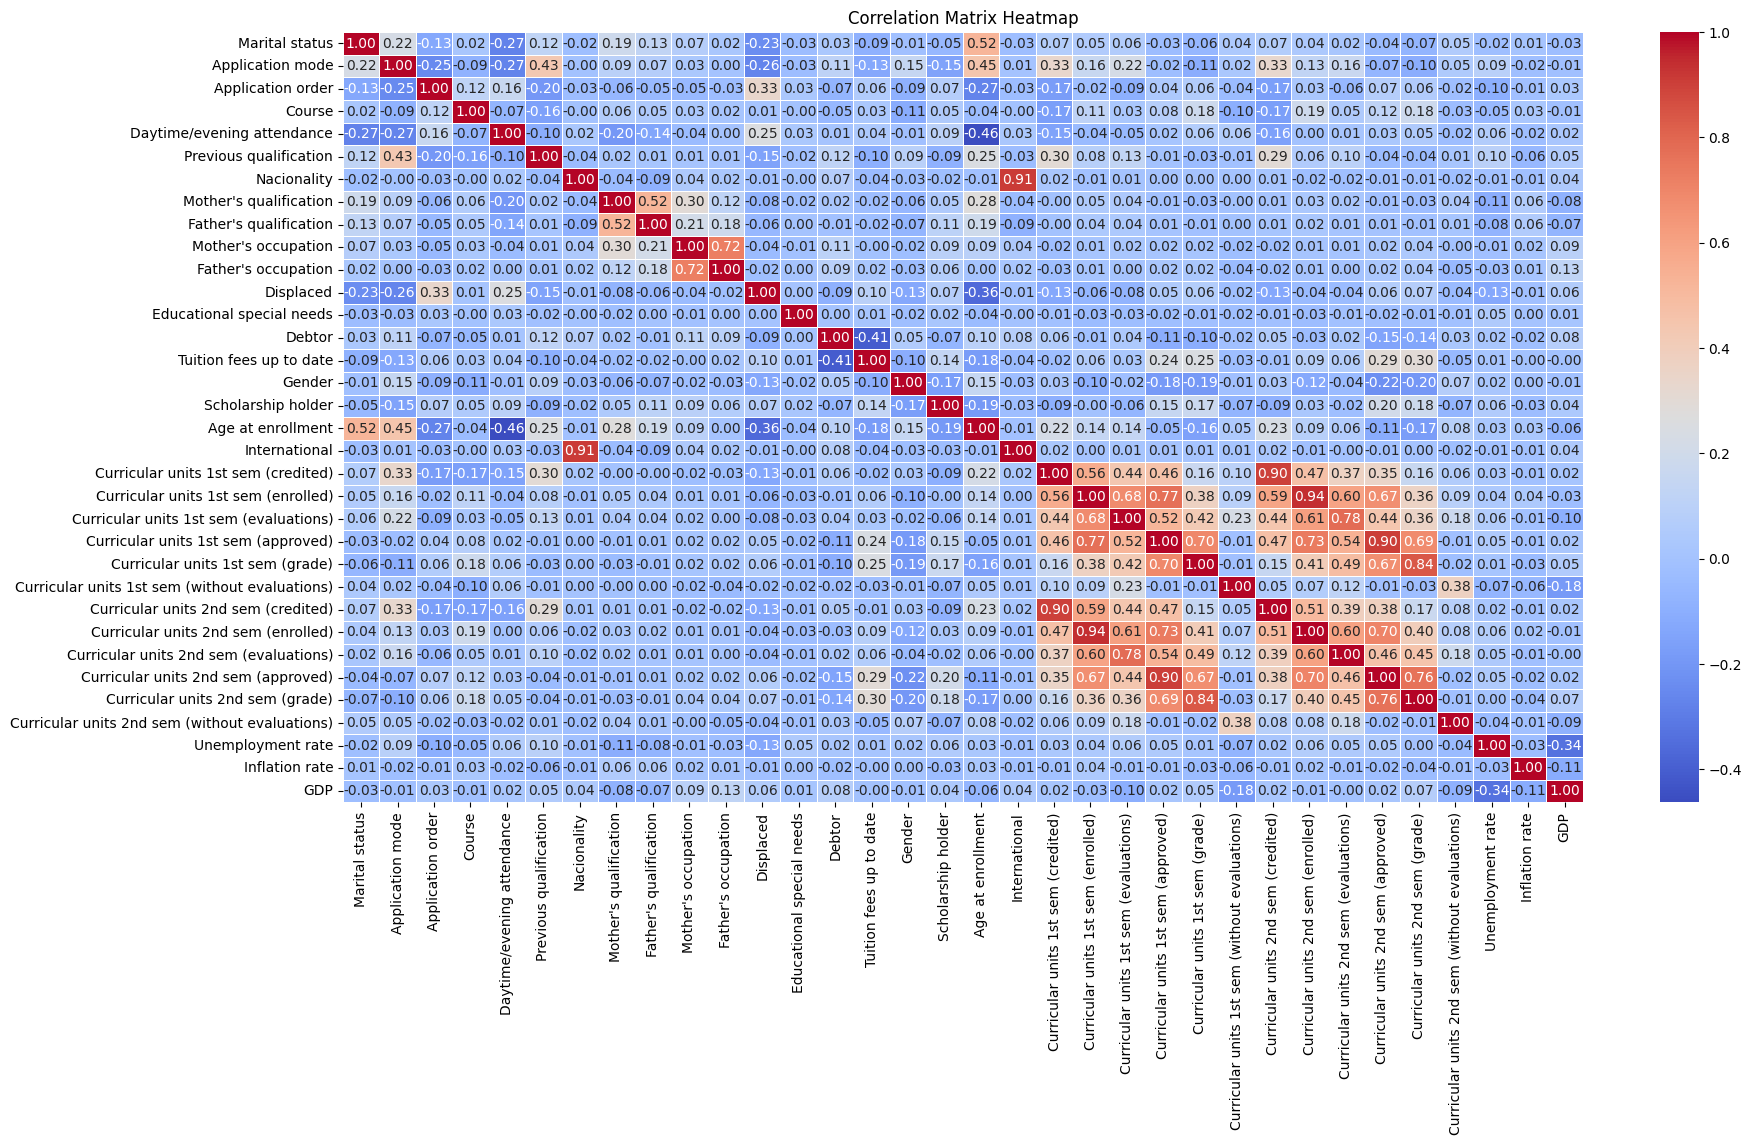

In [8]:
corr_matrix = (data[data.columns[:-1]]).corr()

# Heatmap 시각화
plt.figure(figsize=(20, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# 제목 추가
plt.title("Correlation Matrix Heatmap")
plt.show()

# Feature selection

## 1 Numerical data
위의 상관계수 heatmap에서 알 수 있듯이, numerical 데이터 중에서

Curricular units 1st sem(enrolled) & Curricular units 2nd sem (enrolled)


Curricular units 1st sem(approved) & Curricular units 2nd sem (approved)


Curricular units 1st sem(grade) & Curricular units 2nd sem (grade)


간의 상관계수가 각각 0.94, 0.90, 0.84로 상당히 높다. 

따라서, 두 변수 중 하나의 변수를 제거하는 것이 좋아보이는데, 각 변수는 독립된 기간에 대한 데이터이므로 
1년 동안의 학점수를 나타내는 지표로 두 값을 평균 낸 값을 새로운 지표로 사용하고자 했다.

## 2 Categorical data


Curricular units 1st sem(credited) & Curricular units 2nd sem (credited)


Nationality, International 


간의 상관계수가 0.90, 0.91이므로 각각 둘 중 하나는 빼는 것으로 하는 것이 좋아보임.



In [ ]:
data['Curricular units(enrolled)'] = (data['Curricular units 1st sem (enrolled)'] + data['Curricular units 2nd sem (enrolled)']) /2
data['Curricular units(approved)'] = (data['Curricular units 1st sem (approved)'] + data['Curricular units 2nd sem (approved)']) /2
data['Curricular units(grade)'] = (data['Curricular units 1st sem (grade)'] + data['Curricular units 2nd sem (grade)']) /2

drop_list = ['Curricular units 1st sem (enrolled)', 'Curricular units 2nd sem (enrolled)'
             , 'Curricular units 1st sem (approved)', 'Curricular units 2nd sem (approved)'
             , 'Curricular units 1st sem (grade)', 'Curricular units 2nd sem (grade)']

for col in drop_list:
    data = data.drop(col, axis = 1)
    
data = data.drop('Curricular units 2nd sem (credited)', axis = 1)
data = data.drop('International', axis = 1)    


#최종 feature
data.columns

Index(['Marital status', 'Application mode', 'Application order', 'Course',
       'Daytime/evening attendance', 'Previous qualification', 'Nacionality',
       'Mother's qualification', 'Father's qualification',
       'Mother's occupation', 'Father's occupation', 'Displaced',
       'Educational special needs', 'Debtor', 'Tuition fees up to date',
       'Gender', 'Scholarship holder', 'Age at enrollment',
       'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (without evaluations)', 'Unemployment rate',
       'Inflation rate', 'GDP', 'Target', 'Curricular units(enrolled)',
       'Curricular units(approved)', 'Curricular units(grade)'],
      dtype='object')

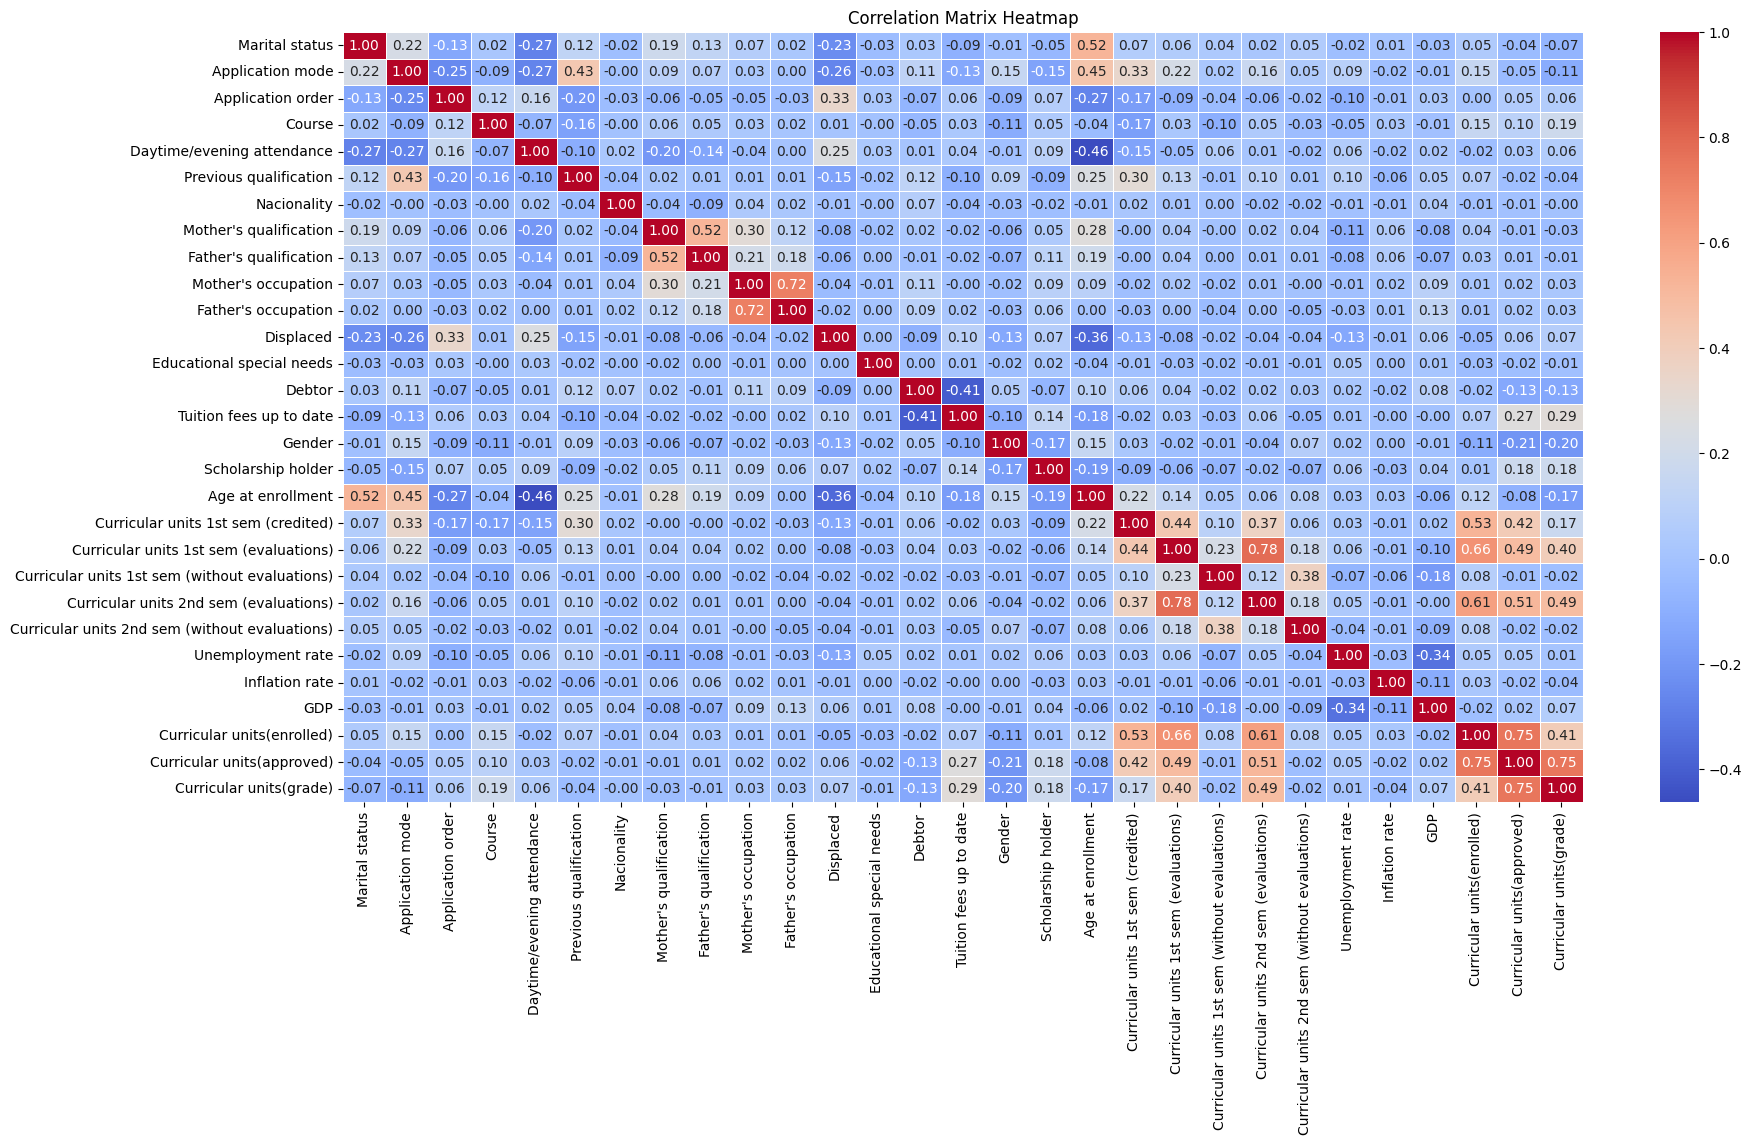

In [11]:
corr_matrix = (data.drop('Target', axis =1)).corr()

# Heatmap 시각화
plt.figure(figsize=(20, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# 제목 추가
plt.title("Correlation Matrix Heatmap")
plt.show()